### Save mask predictions

In [1]:
# Import libs
import os 
import time
import cv2
from tqdm import tqdm
import numpy as np
import skimage.draw
import random
import keras
import cv2
from glob import glob
import warnings
import random
import scipy.io as sio
warnings.filterwarnings('ignore')


import matplotlib.pyplot as plt
import matplotlib.colors
from skimage.transform import resize
import efficientnet.tfkeras
from tensorflow.keras.models import load_model



def create_directory(directory):
    '''
    Creates a new folder in the specified directory if the folder doesn't exist.
    INPUT
        directory: Folder to be created, called as "folder/".
    OUTPUT
        New folder in the current directory.
    '''
    if not os.path.exists(directory):
        os.makedirs(directory)

        
# Name experiment
experiment_name = "unet-dtvpl96-exp-2"
        
    
# Root directory of the project
ROOT_DIR = os.path.abspath(".")
print(ROOT_DIR)

# Model path
log_path = os.path.join(ROOT_DIR, "logs", experiment_name)

# Test file directory
IMAGES_FOLDER = os.path.join(ROOT_DIR, "dataset", "Testing images/")

# Target destination for predictions
PRED_DEST =  os.path.join(ROOT_DIR, "dataset", "the_great_backpropagator_MoNuSAC_test_results")

# Create folders
create_directory(PRED_DEST)

Using TensorFlow backend.


/home/hasib/hasib/MoNuSAC-ISBI-2020


In [2]:
model = None
model = load_model('{}/{}.h5'.format(log_path, experiment_name), compile=False)
#model.summary()

In [3]:
def pad(img, pad_size=64):
    """
    Load image from a given path and pad it on the sides, so that eash side is divisible by 64 (network requirement)
    if pad = True:
        returns image as numpy.array, tuple with padding in pixels as(x_min_pad, y_min_pad, x_max_pad, y_max_pad)
    else:
        returns image as numpy.array
    """

    if pad_size == 0:
        return img

    height, width = img.shape[:2]

    if height % pad_size == 0:
        y_min_pad = 0
        y_max_pad = 0
    else:
        y_pad = pad_size - height % pad_size
        y_min_pad = int(y_pad / 2)
        y_max_pad = y_pad - y_min_pad

    if width % pad_size == 0:
        x_min_pad = 0
        x_max_pad = 0
    else:
        x_pad = pad_size - width % pad_size
        x_min_pad = int(x_pad / 2)
        x_max_pad = x_pad - x_min_pad

    img = cv2.copyMakeBorder(img, y_min_pad, y_max_pad, x_min_pad, x_max_pad, cv2.BORDER_REFLECT_101)

    return img, (x_min_pad, y_min_pad, x_max_pad, y_max_pad)



def unpad(img, pads):
    """
    img: numpy array of the shape (height, width)
    pads: (x_min_pad, y_min_pad, x_max_pad, y_max_pad)
    @return padded image
    """
    (x_min_pad, y_min_pad, x_max_pad, y_max_pad) = pads
    height, width = img.shape[:2]

    return img[y_min_pad:height - y_max_pad, x_min_pad:width - x_max_pad]



def read_nuclei(path):
    "read raw data"

    # Load 4-channel image
    img = skimage.io.imread(path)
    
    # input image
    if len(img.shape) > 2:
        img = img[:,:,:3]
    # mask
    else:
        # do nothing
        pass
        
    return img



def save_nuclei(path, img):
    "save image"
    skimage.io.imsave(path, img)

    
def sliding_window(image, step, window):
    x_loc = []
    y_loc = []
    cells = []
    
    for y in range(0, image.shape[0], step):
        for x in range(0, image.shape[1], step):
            cells.append(image[y:y + window[1], x:x + window[0]])
            x_loc.append(x)
            y_loc.append(y)
    return x_loc, y_loc, cells


def extract_patches(image, step, patch_size):
    
    patches = []
    
    # Get locations
    x_pos, y_pos, cells = sliding_window(image, step, (patch_size[0], patch_size[1]))

    for (x, y, cell) in zip(x_pos, y_pos, cells):

        # Get patch
        patch = image[y:y + patch_size[0], x:x + patch_size[0]]

        # Get size
        raw_dim = (patch.shape[1], patch.shape[0]) # W, H
        #print(raw_dim)
        #print(patch.shape)


        if raw_dim != (patch_size[0], patch_size[1]):

            # Resize to 64x64
            #patch = cv2.resize(patch, (64, 64), interpolation = cv2.INTER_AREA)
            patch, pad_locs = pad(patch, pad_size=patch_size[0])
            
            
            # Do stuffffff
            patches.append(patch)
        
        else:

            # Do stuffffff
            patches.append(patch)
    
    patches = np.array(patches)
    
    return patches
    
# Compute Panoptic quality metric for each image
def Panoptic_quality(ground_truth_image,predicted_image):
    TP = 0
    FP = 0
    FN = 0
    sum_IOU = 0
    matched_instances = {}# Create a dictionary to save ground truth indices in keys and predicted matched instances as velues
                        # It will also save IOU of the matched instance in [indx][1]

    # Find matched instances and save it in a dictionary
    for i in np.unique(ground_truth_image):
        if i == 0:
            pass
        else:
            temp_image = np.array(ground_truth_image)
            temp_image = temp_image == i
            matched_image = temp_image * predicted_image
        
            for j in np.unique(matched_image):
                if j == 0:
                    pass
                else:
                    pred_temp = predicted_image == j
                    intersection = sum(sum(temp_image*pred_temp))
                    union = sum(sum(temp_image + pred_temp))
                    IOU = intersection/union
                    if IOU> 0.5:
                        matched_instances [i] = j, IOU 
                        
    # Compute TP, FP, FN and sum of IOU of the matched instances to compute Panoptic Quality               
                        
    pred_indx_list = np.unique(predicted_image)
    pred_indx_list = np.array(pred_indx_list[1:])

    # Loop on ground truth instances
    for indx in np.unique(ground_truth_image):
        if indx == 0:
            pass
        else:
            if indx in matched_instances.keys():
                pred_indx_list = np.delete(pred_indx_list, np.argwhere(pred_indx_list == [indx][0]))
                TP = TP+1
                sum_IOU = sum_IOU+matched_instances[indx][1]
            else:
                FN = FN+1
    FP = len(np.unique(pred_indx_list))
    PQ = sum_IOU/(TP+0.5*FP+0.5*FN)
    
    return PQ

In [4]:
# SAME CODE BLOCK AS IN 6_inference.ipynb

import numpy as np
from skimage.transform import resize

# Helper function for data visualization
def visualize(**images):
    """Plot images in one row."""
    
    norm=plt.Normalize(0,4) # 5 classes including BG
    map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "red","yellow","blue", "green"])

    
    n = len(images)
    plt.figure(figsize=(18, 16))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap=map_name, norm=norm)
    plt.show()
    
    
    
def prep(img):
    img = img.astype('float32')
    img = (img > 0.5).astype(np.uint8)  # threshold
    img = resize(img, (image_cols, image_rows), preserve_range=True)
    return img




def visualize_results(image, mask):
    
    f, axarr = plt.subplots(1,2, figsize=(16, 16))
    
    norm=plt.Normalize(0,4) # 5 classes including BG
    map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "red","yellow","blue", "green"])

    axarr[0].imshow(image)
    axarr[1].imshow(mask, cmap=map_name, norm=norm)


    
def vis_gray(image, mask):
    
    f, axarr = plt.subplots(1,2, figsize=(16, 16))
    
    axarr[0].imshow(image)
    axarr[1].imshow(mask, cmap='gray')



def predict(im):
    """Predict on patch"""
    
    im = np.expand_dims(im, axis=0)
    
    im = model.predict(im)
    im = np.argmax(im.squeeze(), axis=-1)
 
    #assert im.shape == (96, 96), "Wrong shape, {}!".format(im.shape)
    
    return im



def whole_slide_predict(whole_image):
    
    #import pdb; pdb.set_trace()
    
    # If input image less than patch, infer on whole image
    if whole_image.shape[0] < 96 or whole_image.shape[1] < 96:
        
        # Get size
        raw_dim = (whole_image.shape[1], whole_image.shape[0]) # W, H
        
        # Resize to 64x64 for prediction
        #whole_image_rs = cv2.resize(whole_image, (64, 64), interpolation = cv2.INTER_AREA)
        whole_image_rs, pad_locs = pad(whole_image, pad_size=96)
        
        
        # Infer
        pred = predict(whole_image_rs)
        
        
        # Resize back to original shape
        #pred = cv2.resize(pred, raw_dim, interpolation = cv2.INTER_AREA)
        pred = unpad(pred, pad_locs)
        
        # Change dtype for resizing back to original shape
        pred = pred.astype(np.uint8)
        
      
    else:
        
        # Get patch locations
        x_pos, y_pos, cells = sliding_window(whole_image, 96, (96, 96)) 

        # Array for storing predictions
        pred = np.zeros((whole_image.shape[0], whole_image.shape[1])).astype(np.uint8)

        # Slide over each patch
        for (x, y, cell) in zip(x_pos, y_pos, cells):

            # Get patch
            patch = whole_image[y:y + 96, x:x + 96]

            # Get size
            raw_dim = (patch.shape[1], patch.shape[0]) # W, H

            # If less than patch size, resize and then run prediction
            if raw_dim != (96, 96):


                # Resize to 64x64
                #patch_rs = cv2.resize(patch, (64, 64), interpolation = cv2.INTER_AREA)
                patch_rs, pad_locs = pad(patch, pad_size=96)
                
                #print(patch.dtype, processed.dtype)
                
                assert patch.dtype == patch_rs.dtype, "Wrong data type after resizing!"

                
                # Infer
                processed = predict(patch_rs)
                
                # Resize back to original shape
                #processed = cv2.resize(processed, raw_dim, interpolation = cv2.INTER_AREA)
                processed = unpad(processed, pad_locs)
                
                # Change dtype 
                processed = processed.astype(np.uint8)
                
                assert patch.shape[:2] == processed.shape, "Wrong shape!"
                assert patch.dtype == processed.dtype, "Wrong data type in prediction!"

            else:

                
                # Infer
                processed = predict(patch)
                
                # Change dtype
                processed = processed.astype(np.uint8)

                #print(patch.dtype, processed.dtype)
                

                assert patch.shape[:2] == processed.shape, "Wrong shape!"
                assert patch.dtype == processed.dtype, "Wrong data type in prediction!"


            # Add in image variable
            pred[y:y + 96, x:x + 96] = processed 
            processed = None

    return pred


label_map = {'Epithelial':1,
             'Lymphocyte':2,
             'Macrophage':4,
             'Neutrophil':3,
            }


### Save masks in folders

In [5]:
# Test images sub-folder
IMAGES_SUB_FOLDER = [os.path.join(IMAGES_FOLDER, i) for i in sorted(next(os.walk(IMAGES_FOLDER))[1])]


# Test image path
image_paths = []

# STORE IMAGES in test folder together
raw_ct = 0
for ct in tqdm(range(len(IMAGES_SUB_FOLDER[:]))):
    
    #print(ct)
    
    # Read all raw images in image sub folder
    all_imgs = sorted(glob(IMAGES_SUB_FOLDER[ct] + '/*.tif'))
    pn = IMAGES_SUB_FOLDER[ct].split('.')[0][-23:]
    
    print("Patient name ----------------------> : ", pn)
    
    # Create patient folder
    pn_folder = os.path.join(PRED_DEST, pn)
    create_directory(pn_folder)
    
    # Test set sub folder image paths
    paths = [s.split('.')[0][-25:] for s in all_imgs]
    
    
    # Iterate over the individual raw images
    for i in range(len(all_imgs)):
        
        # Read test image
        image_paths.append(all_imgs[i])
        img = read_nuclei(all_imgs[i])
        
        print("Sub image: ", paths[i])
        
        # Create sub sub folder -> each image for a patient
        patient_sub_folder = os.path.join(pn_folder, paths[i])
        create_directory(patient_sub_folder)
        
        # For each sub folder make subsub folder for each cell type
        epi_path = os.path.join(patient_sub_folder, "Epithelial")
        lym_path = os.path.join(patient_sub_folder, "Lymphocyte")
        neu_path = os.path.join(patient_sub_folder, "Neutrophil")
        macro_path = os.path.join(patient_sub_folder, "Macrophage")
        
        # Creat subsub folders
        create_directory(epi_path)
        create_directory(lym_path)
        create_directory(neu_path)
        create_directory(macro_path)
        
        
        # Predict whole slide image
        pred = whole_slide_predict(img)
        
        # Post processing to refine predictions
        pred_filt = cv2.medianBlur(pred.astype(np.uint8), 5)

        #print(img.shape, pred.shape)
        #print("Uniques predicted", np.unique(pred_filt))

        # Make dummy mask
        zero_mask = np.zeros((pred_filt.shape[0], pred_filt.shape[1])).astype(np.uint8)

        epi_mask = np.where(pred_filt != 1, zero_mask, 1)
        lym_mask = np.where(pred_filt != 2, zero_mask, 2)
        neu_mask = np.where(pred_filt != 3, zero_mask, 3)
        macro_mask = np.where(pred_filt != 4, zero_mask, 4)
        
        # Save masks
        if np.unique(epi_mask)[-1] != 0:
                #np.save("{}/{}.npy".format(epi_path, raw_ct), epi_mask)
                sio.savemat("{}/{}.mat".format(epi_path, raw_ct), {'epi_mask':epi_mask})
        
        raw_ct+=1

        if np.unique(lym_mask)[-1] != 0:
                #np.save("{}/{}.npy".format(lym_path, raw_ct), lym_mask)
                sio.savemat("{}/{}.mat".format(lym_path, raw_ct), {'lym_mask':lym_mask})
                
        raw_ct+=1
        
        if np.unique(neu_mask)[-1] != 0:
                #np.save("{}/{}.npy".format(neu_path, raw_ct), neu_mask)
                sio.savemat("{}/{}.mat".format(neu_path, raw_ct), {'neu_mask':neu_mask})
                
        raw_ct+=1
        
        if np.unique(macro_mask)[-1] != 0:
                #np.save("{}/{}.npy".format(macro_path, raw_ct), macro_mask)
                sio.savemat("{}/{}.mat".format(macro_path, raw_ct), {'macro_mask':macro_mask})
                
        raw_ct+=1

  0%|          | 0/25 [00:00<?, ?it/s]

Patient name ----------------------> :  TCGA-2Z-A9JG-01Z-00-DX1
Sub image:  TCGA-2Z-A9JG-01Z-00-DX1_1
Sub image:  TCGA-2Z-A9JG-01Z-00-DX1_2
Sub image:  TCGA-2Z-A9JG-01Z-00-DX1_3
Sub image:  TCGA-2Z-A9JG-01Z-00-DX1_4
Sub image:  TCGA-2Z-A9JG-01Z-00-DX1_5
Sub image:  TCGA-2Z-A9JG-01Z-00-DX1_6


  4%|▍         | 1/25 [00:08<03:19,  8.32s/it]

Patient name ----------------------> :  TCGA-2Z-A9JN-01Z-00-DX1
Sub image:  TCGA-2Z-A9JN-01Z-00-DX1_1
Sub image:  TCGA-2Z-A9JN-01Z-00-DX1_2
Sub image:  TCGA-2Z-A9JN-01Z-00-DX1_3
Sub image:  TCGA-2Z-A9JN-01Z-00-DX1_4


  8%|▊         | 2/25 [00:20<03:39,  9.56s/it]

Patient name ----------------------> :  TCGA-49-6743-01Z-00-DX2
Sub image:  GA-49-6743-01Z-00-DX2_001
Sub image:  GA-49-6743-01Z-00-DX2_002
Sub image:  GA-49-6743-01Z-00-DX2_003
Sub image:  GA-49-6743-01Z-00-DX2_004
Sub image:  GA-49-6743-01Z-00-DX2_005


 12%|█▏        | 3/25 [00:33<03:49, 10.45s/it]

Patient name ----------------------> :  TCGA-50-6591-01Z-00-DX1
Sub image:  GA-50-6591-01Z-00-DX1_001


 16%|█▌        | 4/25 [00:36<02:56,  8.40s/it]

Patient name ----------------------> :  TCGA-55-7570-01Z-00-DX1
Sub image:  GA-55-7570-01Z-00-DX1_001


 20%|██        | 5/25 [00:38<02:05,  6.29s/it]

Sub image:  GA-55-7570-01Z-00-DX1_002
Patient name ----------------------> :  TCGA-55-7573-01Z-00-DX1
Sub image:  GA-55-7573-01Z-00-DX1_001
Sub image:  GA-55-7573-01Z-00-DX1_002
Sub image:  GA-55-7573-01Z-00-DX1_003
Sub image:  GA-55-7573-01Z-00-DX1_004


 24%|██▍       | 6/25 [00:46<02:10,  6.86s/it]

Patient name ----------------------> :  TCGA-73-4662-01Z-00-DX1
Sub image:  GA-73-4662-01Z-00-DX1_001
Sub image:  GA-73-4662-01Z-00-DX1_002
Sub image:  GA-73-4662-01Z-00-DX1_003


 28%|██▊       | 7/25 [00:54<02:08,  7.15s/it]

Patient name ----------------------> :  TCGA-78-7152-01Z-00-DX1
Sub image:  GA-78-7152-01Z-00-DX1_001


 32%|███▏      | 8/25 [00:54<01:28,  5.21s/it]

Sub image:  GA-78-7152-01Z-00-DX1_002
Patient name ----------------------> :  TCGA-A2-A04X-01Z-00-DX1
Sub image:  GA-A2-A04X-01Z-00-DX1_001
Sub image:  GA-A2-A04X-01Z-00-DX1_002
Sub image:  GA-A2-A04X-01Z-00-DX1_003
Sub image:  GA-A2-A04X-01Z-00-DX1_004


 36%|███▌      | 9/25 [01:02<01:32,  5.80s/it]

Patient name ----------------------> :  TCGA-A2-A0ES-01Z-00-DX1
Sub image:  GA-A2-A0ES-01Z-00-DX1_001
Sub image:  GA-A2-A0ES-01Z-00-DX1_002
Sub image:  GA-A2-A0ES-01Z-00-DX1_003
Sub image:  GA-A2-A0ES-01Z-00-DX1_004


 40%|████      | 10/25 [01:06<01:21,  5.42s/it]

Patient name ----------------------> :  TCGA-D8-A3Z6-01Z-00-DX2
Sub image:  GA-D8-A3Z6-01Z-00-DX2_001
Sub image:  GA-D8-A3Z6-01Z-00-DX2_002
Sub image:  GA-D8-A3Z6-01Z-00-DX2_003
Sub image:  GA-D8-A3Z6-01Z-00-DX2_004


 44%|████▍     | 11/25 [01:12<01:17,  5.56s/it]

Patient name ----------------------> :  TCGA-DW-7838-01Z-00-DX1
Sub image:  TCGA-DW-7838-01Z-00-DX1_1
Sub image:  TCGA-DW-7838-01Z-00-DX1_2
Sub image:  TCGA-DW-7838-01Z-00-DX1_3
Sub image:  TCGA-DW-7838-01Z-00-DX1_4
Sub image:  TCGA-DW-7838-01Z-00-DX1_5


 48%|████▊     | 12/25 [01:17<01:09,  5.34s/it]

Patient name ----------------------> :  TCGA-DW-7963-01Z-00-DX1
Sub image:  TCGA-DW-7963-01Z-00-DX1_1
Sub image:  TCGA-DW-7963-01Z-00-DX1_2
Sub image:  TCGA-DW-7963-01Z-00-DX1_3
Sub image:  TCGA-DW-7963-01Z-00-DX1_4
Sub image:  TCGA-DW-7963-01Z-00-DX1_5


 52%|█████▏    | 13/25 [01:19<00:51,  4.29s/it]

Patient name ----------------------> :  TCGA-E2-A108-01Z-00-DX1
Sub image:  GA-E2-A108-01Z-00-DX1_001
Sub image:  GA-E2-A108-01Z-00-DX1_002
Sub image:  GA-E2-A108-01Z-00-DX1_003
Sub image:  GA-E2-A108-01Z-00-DX1_004
Sub image:  GA-E2-A108-01Z-00-DX1_005


 56%|█████▌    | 14/25 [01:25<00:54,  4.93s/it]

Patient name ----------------------> :  TCGA-EW-A6SB-01Z-00-DX1
Sub image:  GA-EW-A6SB-01Z-00-DX1_001
Sub image:  GA-EW-A6SB-01Z-00-DX1_002
Sub image:  GA-EW-A6SB-01Z-00-DX1_003
Sub image:  GA-EW-A6SB-01Z-00-DX1_004
Sub image:  GA-EW-A6SB-01Z-00-DX1_005


 60%|██████    | 15/25 [01:28<00:43,  4.40s/it]

Patient name ----------------------> :  TCGA-F9-A8NY-01Z-00-DX1
Sub image:  TCGA-F9-A8NY-01Z-00-DX1_1
Sub image:  TCGA-F9-A8NY-01Z-00-DX1_2
Sub image:  TCGA-F9-A8NY-01Z-00-DX1_3


 64%|██████▍   | 16/25 [01:40<01:00,  6.71s/it]

Sub image:  TCGA-F9-A8NY-01Z-00-DX1_4
Patient name ----------------------> :  TCGA-G9-6356-01Z-00-DX1
Sub image:  TCGA-G9-6356-01Z-00-DX1_1
Sub image:  TCGA-G9-6356-01Z-00-DX1_3
Sub image:  TCGA-G9-6356-01Z-00-DX1_4
Sub image:  TCGA-G9-6356-01Z-00-DX1_5
Sub image:  TCGA-G9-6356-01Z-00-DX1_6


 68%|██████▊   | 17/25 [01:48<00:54,  6.86s/it]

Patient name ----------------------> :  TCGA-G9-6367-01Z-00-DX1
Sub image:  TCGA-G9-6367-01Z-00-DX1_1
Sub image:  TCGA-G9-6367-01Z-00-DX1_2
Sub image:  TCGA-G9-6367-01Z-00-DX1_3
Sub image:  TCGA-G9-6367-01Z-00-DX1_4
Sub image:  TCGA-G9-6367-01Z-00-DX1_5
Sub image:  TCGA-G9-6367-01Z-00-DX1_6
Sub image:  TCGA-G9-6367-01Z-00-DX1_7


 72%|███████▏  | 18/25 [01:56<00:50,  7.26s/it]

Patient name ----------------------> :  TCGA-IZ-A6M9-01Z-00-DX1
Sub image:  TCGA-IZ-A6M9-01Z-00-DX1_1
Sub image:  TCGA-IZ-A6M9-01Z-00-DX1_2
Sub image:  TCGA-IZ-A6M9-01Z-00-DX1_3


 76%|███████▌  | 19/25 [02:05<00:46,  7.68s/it]

Patient name ----------------------> :  TCGA-MH-A55W-01Z-00-DX1
Sub image:  TCGA-MH-A55W-01Z-00-DX1_1
Sub image:  TCGA-MH-A55W-01Z-00-DX1_2
Sub image:  TCGA-MH-A55W-01Z-00-DX1_3
Sub image:  TCGA-MH-A55W-01Z-00-DX1_4


 80%|████████  | 20/25 [02:05<00:27,  5.44s/it]

Patient name ----------------------> :  TCGA-MP-A4T7-01Z-00-DX1
Sub image:  GA-MP-A4T7-01Z-00-DX1_001
Sub image:  GA-MP-A4T7-01Z-00-DX1_002
Sub image:  GA-MP-A4T7-01Z-00-DX1_003
Sub image:  GA-MP-A4T7-01Z-00-DX1_004
Sub image:  GA-MP-A4T7-01Z-00-DX1_005


 84%|████████▍ | 21/25 [02:10<00:21,  5.33s/it]

Patient name ----------------------> :  TCGA-VP-A87E-01Z-00-DX1
Sub image:  TCGA-VP-A87E-01Z-00-DX1_1
Sub image:  TCGA-VP-A87E-01Z-00-DX1_2
Sub image:  TCGA-VP-A87E-01Z-00-DX1_3
Sub image:  TCGA-VP-A87E-01Z-00-DX1_4
Sub image:  TCGA-VP-A87E-01Z-00-DX1_5


 88%|████████▊ | 22/25 [02:20<00:20,  6.89s/it]

Patient name ----------------------> :  TCGA-VP-A87H-01Z-00-DX1
Sub image:  TCGA-VP-A87H-01Z-00-DX1_1
Sub image:  TCGA-VP-A87H-01Z-00-DX1_2
Sub image:  TCGA-VP-A87H-01Z-00-DX1_5
Sub image:  TCGA-VP-A87H-01Z-00-DX1_6


 92%|█████████▏| 23/25 [02:29<00:14,  7.49s/it]

Patient name ----------------------> :  TCGA-X4-A8KS-01Z-00-DX3
Sub image:  TCGA-X4-A8KS-01Z-00-DX3_1


 96%|█████████▌| 24/25 [02:31<00:05,  5.78s/it]

Patient name ----------------------> :  TCGA-YL-A9WL-01Z-00-DX1
Sub image:  TCGA-YL-A9WL-01Z-00-DX1_1
Sub image:  TCGA-YL-A9WL-01Z-00-DX1_2
Sub image:  TCGA-YL-A9WL-01Z-00-DX1_3
Sub image:  TCGA-YL-A9WL-01Z-00-DX1_4


100%|██████████| 25/25 [02:34<00:00,  6.18s/it]


### Run inference on a random single image

Index:  72
Image shape: (446, 512, 3)
uint8
(446, 512, 3) (446, 512)
Uniques predicted [0 1 2 3]
(446, 512) (446, 512) (446, 512) (446, 512)
Epi mask uniques predicted [0 1]
Lym mask uniques predicted [0 2]
Neu mask uniques predicted [0 3]
Macro mask uniques predicted [0]


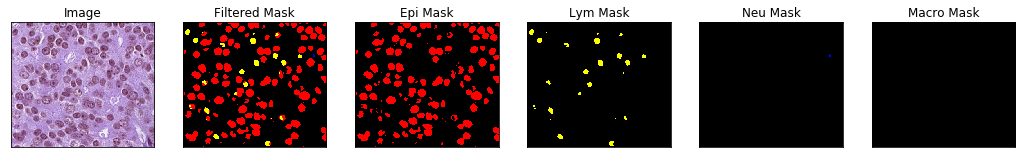

In [7]:
idx = random.randrange(len(image_paths))
print("Index: ",idx)

image = read_nuclei(image_paths[-1])
print("Image shape:", image.shape)

pred = whole_slide_predict(image)
print(pred.dtype)

# Post processing to refine predictions
pred_filt = cv2.medianBlur(pred.astype(np.uint8), 5)

print(image.shape, pred.shape)
print("Uniques predicted", np.unique(pred))

zero_mask = np.zeros((pred_filt.shape[0], pred_filt.shape[1])).astype(np.uint8)

epi_mask = np.where(pred_filt != 1, zero_mask, 1)
lym_mask = np.where(pred_filt != 2, zero_mask, 2)
neu_mask = np.where(pred_filt != 3, zero_mask, 3)
macro_mask = np.where(pred_filt != 4, zero_mask, 4)

print(epi_mask.shape, lym_mask.shape, neu_mask.shape, macro_mask.shape)
print("Epi mask uniques predicted", np.unique(epi_mask))
print("Lym mask uniques predicted", np.unique(lym_mask))
print("Neu mask uniques predicted", np.unique(neu_mask))
print("Macro mask uniques predicted", np.unique(macro_mask))
      
visualize(
        image=image,
        Filtered_mask = pred_filt,
        Epi_mask = epi_mask,
        Lym_mask = lym_mask,
        Neu_mask = neu_mask,
        Macro_mask = macro_mask)

In [ ]:
#!conda env export > environment.yml    